In [38]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

sys.path.append("../")
from utils.io import read_parameters
from src.plot_trajectories import plot_trajectories_per_file
from src.plot_trajectories import plot_trajectories_from_origin_per_file
from src.plot_trajectories import plot_trajectories_from_origin_per_condition
from src.plot_trajectories import normalize_speed

cmap = matplotlib.colormaps["seismic"]

In [39]:
# read parameters and key file

parameter_file  = "../local/parameters.yml"
parameters = read_parameters(parameter_file)       

key_file_path = parameters["key_file"]
key_file = pd.read_csv(key_file_path)

print("key file columns:", key_file.columns)
print("key file conditions:", key_file["condition"].unique())

key file columns: Index(['experimentID', 'filename', 'color', 'mosaic', 'treatment', 'condition',
       'date'],
      dtype='object')
key file conditions: ['mosaic_siCTRL_siCTRL' 'mosaic_siCTRL_siAlk1' 'mosaic_siCTRL_siSMAD4']


In [40]:
# create output folder

output_folder = parameters["output_folder"]
print("Output folder:", output_folder)

data_folder = output_folder + "/tracking_data/"

subfolder = "trajectory_plots"
if not os.path.exists(output_folder + "/" + subfolder):
    os.mkdir(output_folder + "/" + subfolder)

#tracking_data = pd.read_csv(data_folder + "tracking_data.csv") 


Output folder: /media/fjodor/Elephant/Dropbox/MDC_Projects/Olya_migration/mosaic/output_olya_mosaic_20240610/


In [41]:
# plot paramters

condition = 'mosaic_siCTRL_siAlk1'
color = 'red'
treatment = 'siAlk1'

number_of_tracks_per_condition = 1000

observation_time = parameters["observation_time"]

min_speed = -35.0 # um/h
max_speed = 35.0 # um/h

max_x = 50.0 # um
max_y = 50.0 # um

sample 250 tracks per file
     TRACK_ID
0         108
1         546
2         612
3         124
4         319
..        ...
311       449
312       445
313        65
314       207
315       235

[316 rows x 1 columns]
Available tracks: 501
sampled 250 tracks for file tracking_data_siAlk1_red_230804_iCTRL_siAlk1.csv
     TRACK_ID
0         230
1         337
2         486
3          39
4         499
..        ...
208       398
209        99
210       662
211       188
212       415

[213 rows x 1 columns]
Available tracks: 399
sampled 250 tracks for file tracking_data_siAlk1_red_230811_iCTRL_siAlk1.csv
     TRACK_ID
0         182
1         823
2         184
3         133
4         177
..        ...
239       447
240       448
241       450
242       446
243       434

[244 rows x 1 columns]
Available tracks: 433
sampled 250 tracks for file tracking_data_siAlk1_red_230817_iCTRL_siAlk1.csv
     TRACK_ID
0         169
1           3
2         205
3         206
4           5
..        ...
28

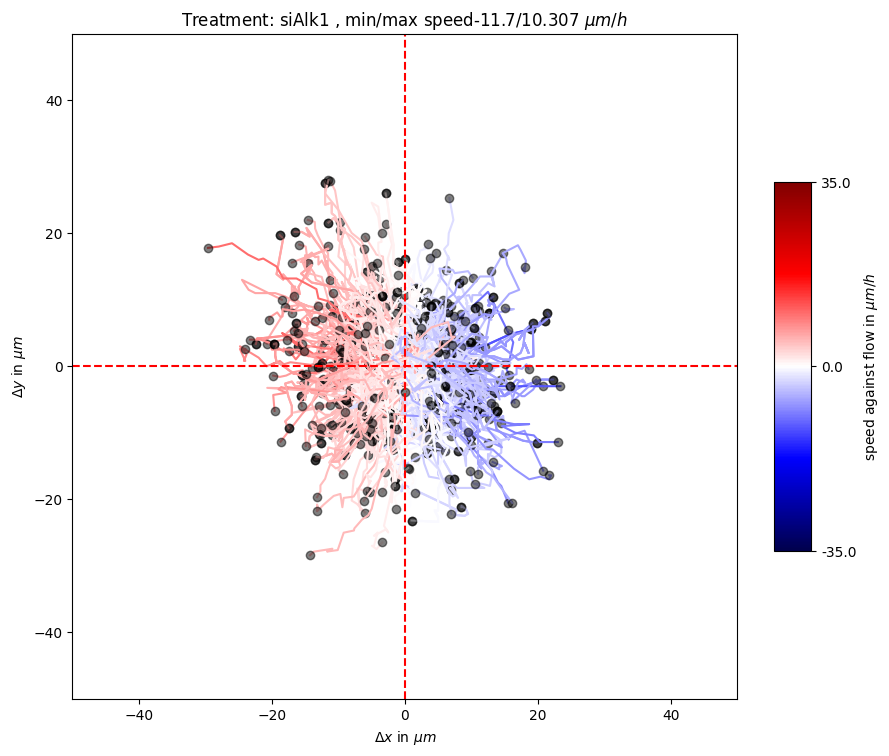

<Figure size 640x480 with 0 Axes>

In [50]:
#key_select = key_file[key_file["condition"] == ]
#key_select = key_select[key_select["color"] == color]
key_select = key_file[key_file["treatment"] == treatment] 

number_of_tracks_per_file = int(number_of_tracks_per_condition/len(key_select.index))
print("sample %s tracks per file" % number_of_tracks_per_file)

track_counter = 0
center_x = 0
center_y = 0
max_vel = 0
min_vel = 0

fig, ax = plt.subplots(figsize=(9,9))

obs_time_length_frames = observation_time[1] - observation_time[0]
obs_time_length_hour = (observation_time[1] - observation_time[0])/parameters["frames_per_hour"]

for index, row in key_select.iterrows():

    tracking_file = "tracking_data_%s_%s_%s.csv" % (treatment, row["color"], row["experimentID"])
                
    data = pd.read_csv(data_folder+ tracking_file, low_memory=False)

    observation_period_df = data[data["FRAME"] <= observation_time[1]]
    observation_period_df = observation_period_df[observation_period_df["FRAME"] >= observation_time[0]]

    # Get the first frame of each track
    tracks_start = observation_period_df[observation_period_df["FRAME"] == observation_time[0]]
    tracks_end = observation_period_df[observation_period_df["FRAME"] == observation_time[1]]

    common_tracks = pd.merge(tracks_start[['TRACK_ID']], tracks_end[['TRACK_ID']], on='TRACK_ID', how='inner')
    print(common_tracks)
    unique_common_track_ids = common_tracks['TRACK_ID'].unique()

    if parameters["allow_tracks_shorter_than_observation_time"] == True:
        trackID_list = np.array(tracks_start["TRACK_ID"].unique())
    else:
        trackID_list = np.array(unique_common_track_ids)

    #print(tracks_start)

    # Group by 'track_id' and get the first and last entry for each track
    #start_points = observation_period_df.groupby('TRACK_ID').first().reset_index()[['TRACK_ID', "POSITION_X", "POSITION_Y"]]
    #end_points = observation_period_df.groupby('TRACK_ID').last().reset_index()[['TRACK_ID', "POSITION_X", "POSITION_Y"]]

    # Optionally, rename columns for clarity
    #start_points.rename(columns={"POSITION_X": 'start_x', "POSITION_Y": 'start_y'}, inplace=True)
    #end_points.rename(columns={"POSITION_X": 'end_x', "POSITION_Y": 'end_y'}, inplace=True)

    # Merge start and end points into a single DataFrame for convenience
    #track_points = pd.merge(start_points, end_points, on='TRACK_ID')

    #print(track_points)


    
    print("Available tracks: %s" % len(trackID_list))
    trackID_list = np.random.choice(trackID_list, number_of_tracks_per_file)

    print("sampled %s tracks for file %s" % (len(trackID_list),tracking_file))
    track_counter += len(trackID_list)

    center_per_file_x = 0.0
    center_per_file_y = 0.0
    total_dist_per_file = 0.0

    for track_id in trackID_list:
        single_track_df = observation_period_df[observation_period_df["TRACK_ID"] == track_id].copy()

        start_frame = single_track_df["FRAME"].min()
        end_frame = single_track_df["FRAME"].max()
        delta_frame = end_frame - start_frame
        delta_hour = delta_frame/parameters["frames_per_hour"]

        row_start = single_track_df[single_track_df["FRAME"] == start_frame]
        row_end = single_track_df[single_track_df["FRAME"] == end_frame]

        start_x = np.array(row_start["POSITION_X"])[0]
        start_y = np.array(row_start["POSITION_Y"])[0]
        end_x = np.array(row_end["POSITION_X"])[0]
        end_y = np.array(row_end["POSITION_Y"])[0]
        delta_x = end_x - start_x
        delta_y = end_y - start_y

        single_track_df["X_from_origin"] = single_track_df["POSITION_X"] - start_x
        single_track_df["Y_from_origin"] = single_track_df["POSITION_Y"] - start_y

        #end_x = np.array(single_track_df["ORIGIN_X"])[-1]
        #end_y = np.array(single_track_df["ORIGIN_Y"])[-1]

        total_dist_per_file += np.sqrt(delta_x**2 + delta_y**2)

        center_x += delta_x
        center_y += delta_y

        center_per_file_x += delta_x
        center_per_file_y += delta_y

        rel_vel = normalize_speed(-delta_x/delta_hour, min_speed, max_speed)

        if - delta_x/delta_hour > max_vel:
            max_vel = - delta_x/delta_hour
        if - delta_x/delta_hour < min_vel:
            min_vel = - delta_x/delta_hour

                    # ax.plot(single_track_df["ORIGIN_X"],single_track_df["ORIGIN_Y"], color = "#ff7f00")
                    # ax.plot([end_x],[end_y], color = "black", marker = "o")

                    # color by track id             
                    #ax.plot(single_track_df["ORIGIN_X"], single_track_df["ORIGIN_Y"])
                    #ax.plot([end_x], [end_y], marker="o")

                    # color by velocity   
        ax.plot(single_track_df["X_from_origin"],single_track_df["Y_from_origin"], color = cmap(rel_vel))
        ax.plot([delta_x],[delta_y], color = "black", marker = "o", alpha=0.5) 

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm, ax=ax, label='speed against flow in $\mu m/h$', aspect=10, fraction = 0.05)
cbar.set_ticks([0.0,0.5,1.0])
# Optionally, set tick labels if you want to customize them further
mid_speed = (max_speed + min_speed)/2
cbar.set_ticklabels([min_speed, mid_speed, max_speed])


print("sampled %s tracks in total" % track_counter)
print("max velocity: ", max_vel, " um/h: ", " min velocity: ", min_vel, " um/h: ")

ax.set_xlim(-max_x,max_y)
ax.set_ylim(-max_x,max_y)
ax.axhline(0, color = "red", linestyle = "--")
ax.axvline(0, color = "red", linestyle = "--")
title = ("Treatment: " + treatment 
         + " , min/max speed" + str(np.round(min_vel,3)) 
         + "/" + str(np.round(max_vel,3)) + " $\mu m/h$" )
#ax.set_title(treatment)
ax.set_title(title)
ax.set_xlabel("$\Delta x$ in $\mu m$")
ax.set_ylabel("$\Delta y$ in $\mu m$")
ax.set_aspect(1)
plt.tight_layout()
plt.show()
plt.savefig(output_folder + "/" + subfolder + "/" + "trajectories_" + treatment + ".pdf")
plt.savefig(output_folder + "/" + subfolder + "/" + "trajectories_" + treatment + ".png")

In [43]:
#single_condition_data = tracking_data[tracking_data["condition"] == condition]
#single_color_data = single_condition_data[single_condition_data["color"] == color]
#single_color_data = single_color_data[data["FRAME"] <= parameters["observation_period"][1]]
#ingle_color_data = single_color_data[data["FRAME"] >= parameters["observation_period"][0]]

In [44]:
# plot_trajectories_from_origin_per_condition(parameters, key_file, subfolder = "tracking_data", number_of_tracks_per_condition = parameters["number_of_cells_per_condition"])